#Categorize Sentiment of Pandamic Tweets using NLP



> Sentiment is wherever you go.



---



##Download and Import Libraries:

In [ ]:
# Download libraries
!pip install -q tensorflow
!pip install -q keras
!pip install -q nltk

In [ ]:
# Download Word2Vec 'GloVe' for embedding
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Download dependencies
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

##Dataset Extraction:

In [ ]:
file_link = 'https://drive.google.com/file/d/1CRwqCQlJ7RYWd6YrCsaZqJwrtnP1qTWy/view?usp=sharing'

id = file_link.split("/")[-2]

new_link = f'https://drive.google.com/uc?id={id}'
df = pd.read_csv(new_link, encoding='ISO-8859-1')

##Dataset Pre-Process & Visualize:

In [ ]:
# Drop unnecessary columns
df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'], inplace=True)

In [ ]:
# Structure of Dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"Columns in the dataset: {list(df.columns)}")

print()

# Number of unique values in each column
unique_values = df.nunique()
print("Number of unique values per column:")
print(unique_values)

df.head(3)

Dataset contains 41157 rows and 2 columns.
Columns in the dataset: ['OriginalTweet', 'Sentiment']

Number of unique values per column:
OriginalTweet    41157
Sentiment            5
dtype: int64


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive


Text(0.5, 1.0, 'The distribution of message sentiments')

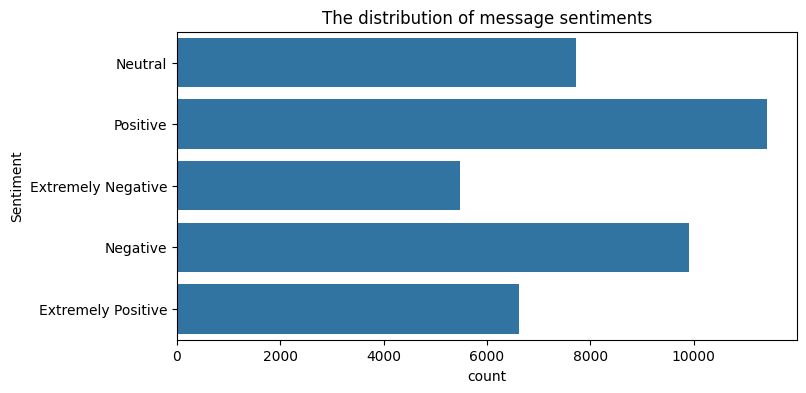

In [ ]:
# Visualize dataset
plt.figure(figsize=(8,4))
sns.countplot(df.Sentiment)
plt.title('The distribution of message sentiments')

In [ ]:
# Get POS tags for more accurate lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Clean Texts
def clean_text(text):
    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()

    # Lemmatize each word after removing stop words
    lemmatizer = WordNetLemmatizer()
    filtered_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(word))
        for word in words if word.lower() not in stop_words
    ]

    text = ' '.join(filtered_words)

    # Only keep specific punctuation and characters
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()/-]", " ", text)

    # Reduce repetitions of characters to single occurrences
    text = re.sub(r"([.,!?;:'\"()/-])\1+", r"\1", text)

    return text

df['CleanedTweet'] = df['OriginalTweet'].apply(clean_text)
df.drop(columns=['OriginalTweet'], inplace=True)

In [ ]:
# Initialize the OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the 'Sentiment' column
sentiment_encoded = one_hot_encoder.fit_transform(df[['Sentiment']])

# Convert the result to a DataFrame with appropriate column names
sentiment_encoded_df = pd.DataFrame(sentiment_encoded, columns=one_hot_encoder.get_feature_names_out(['Sentiment']))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([df, sentiment_encoded_df], axis=1)

In [ ]:
df.drop(columns=['Sentiment'], inplace=True)
df.head(3)

,CleanedTweet,Sentiment_Extremely Negative,Sentiment_Extremely Positive,Sentiment_Negative,Sentiment_Neutral,Sentiment_Positive
0,MeNyrbie Phil Gahan Chrisitv,0.0,0.0,0.0,1.0,0.0
1,advice Talk neighbour family exchange phone nu...,0.0,0.0,0.0,0.0,1.0
2,Coronavirus Australia: Woolworths give elderly...,0.0,0.0,0.0,0.0,1.0


##Split Dataset into Train-Test-Validate:

In [ ]:
# Split dataset for train-test-validate

X = df['CleanedTweet']
y = df[['Sentiment_Extremely Negative', 'Sentiment_Extremely Positive', 'Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive']].values  # One-hot encoded sentiments

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

##Dataset > Feedable to Models:

In [ ]:
# Unique words
all_text = ' '.join(df['CleanedTweet'])
unique_words = len(set(all_text.split()))

# Tokenize Texts

tokenizer = Tokenizer(num_words=unique_words, char_level = 'False', oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

# Padding based on max length of a sentence in dataset
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validation_sequences = tokenizer.texts_to_sequences(X_val)

max_length = max(len(seq) for seq in training_sequences)

X_train_padded = pad_sequences(training_sequences, padding='post', maxlen=max_length, truncating='post')
X_test = pad_sequences(testing_sequences, padding='post', maxlen=max_length, truncating='post')
X_val = pad_sequences(validation_sequences, padding='post', maxlen=max_length, truncating='post')

# Undersampling
smote = SMOTE(random_state=44)
X_train, y_train = smote.fit_resample(X_train_padded, y_train)

##GloVe Embedding:

In [ ]:
# Load the GloVe Word Embeddings
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')

            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = vector[:embedding_dim]

    return embedding_matrix

embedding_dim = 300
glove_file_path = 'glove.6B.300d.txt'

embedding_matrix = create_embedding_matrix(glove_file_path, tokenizer.word_index, embedding_dim)

embedding_layer = layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)

##Models:




> LSTM -



In [ ]:
modelLSTM = Sequential()
modelLSTM.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))
modelLSTM.add(layers.Bidirectional(layers.LSTM(128, activation='tanh')))
modelLSTM.add(layers.Dropout(0.2))
modelLSTM.add(layers.Dense(5, activation='softmax'))
modelLSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelLSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 300)         15300     
                                                                 
 bidirectional_8 (Bidirecti  (None, 256)               439296    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 455881 (1.74 MB)
Trainable params: 440581 (1.68 MB)
Non-trainable params: 15300 (59.77 KB)
_________________________________________________________________


In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
y_train_label = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_label), y=y_train_label)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the LSTM model on the training set and validate it on the validation set
historyLSTM = modelLSTM.fit(X_train, y_train, epochs=25, verbose=1, batch_size=50, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight = class_weight_dict)

# Evaluate the model on the train-test set
lossTrain, accuracyTrain = modelLSTM.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracyTrain))
lossTest, accuracyTest = modelLSTM.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracyTest))

Epoch 1/25
914/914 [==============================] - 360s 392ms/step - loss: 1.5618 - accuracy: 0.2634 - val_loss: 1.5627 - val_accuracy: 0.2903
Epoch 2/25
914/914 [==============================] - 332s 363ms/step - loss: 1.4504 - accuracy: 0.3346 - val_loss: 1.5119 - val_accuracy: 0.3107
Epoch 3/25
914/914 [==============================] - 337s 369ms/step - loss: 1.3877 - accuracy: 0.3726 - val_loss: 1.3908 - val_accuracy: 0.3863
Epoch 4/25
914/914 [==============================] - 346s 378ms/step - loss: 1.2932 - accuracy: 0.4303 - val_loss: 1.2885 - val_accuracy: 0.4487
Epoch 5/25
914/914 [==============================] - 349s 382ms/step - loss: 1.2198 - accuracy: 0.4705 - val_loss: 1.1998 - val_accuracy: 0.4891
Epoch 6/25
914/914 [==============================] - 338s 370ms/step - loss: 1.1576 - accuracy: 0.5061 - val_loss: 1.1519 - val_accuracy: 0.5126
Epoch 7/25
914/914 [==============================] - 322s 353ms/step - loss: 1.1049 - accuracy: 0.5353 - val_loss: 1.1164 -



>GRU -



In [ ]:
modelGRU = Sequential()
modelGRU.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))
modelGRU.add(layers.Bidirectional(layers.GRU(128, activation='tanh')))
modelGRU.add(layers.Dropout(0.2))
modelGRU.add(layers.Dense(5, activation='softmax'))
modelGRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelGRU.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 300)         15300     
                                                                 
 bidirectional_9 (Bidirecti  (None, 256)               330240    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 346825 (1.32 MB)
Trainable params: 331525 (1.26 MB)
Non-trainable params: 15300 (59.77 KB)
_________________________________________________________________


In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
y_train_label = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_label), y=y_train_label)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the LSTM model on the training set and validate it on the validation set
historyGRU = modelGRU.fit(X_train, y_train, epochs=25, verbose=1, batch_size=50, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight = class_weight_dict)

# Evaluate the model on the train-test set
lossTrain, accuracyTrain = modelGRU.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracyTrain))
lossTest, accuracyTest = modelGRU.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracyTest))

Epoch 1/25
914/914 [==============================] - 331s 358ms/step - loss: 1.5623 - accuracy: 0.2677 - val_loss: 1.5568 - val_accuracy: 0.2884
Epoch 2/25
914/914 [==============================] - 326s 357ms/step - loss: 1.4145 - accuracy: 0.3576 - val_loss: 1.3968 - val_accuracy: 0.3861
Epoch 3/25
914/914 [==============================] - 322s 352ms/step - loss: 1.3006 - accuracy: 0.4231 - val_loss: 1.2661 - val_accuracy: 0.4551
Epoch 4/25
914/914 [==============================] - 322s 353ms/step - loss: 1.2083 - accuracy: 0.4777 - val_loss: 1.1856 - val_accuracy: 0.4956
Epoch 5/25
914/914 [==============================] - 320s 350ms/step - loss: 1.1427 - accuracy: 0.5169 - val_loss: 1.1473 - val_accuracy: 0.5199
Epoch 6/25
914/914 [==============================] - 318s 348ms/step - loss: 1.0906 - accuracy: 0.5427 - val_loss: 1.0854 - val_accuracy: 0.5578
Epoch 7/25
914/914 [==============================] - 316s 345ms/step - loss: 1.0443 - accuracy: 0.5694 - val_loss: 1.0542 -

##Model Results -



> LSTM Training Accuracy vs Validation Accuracy -




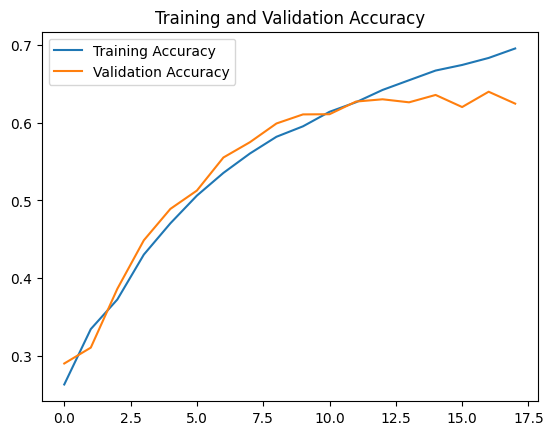

In [ ]:
plt.plot(historyLSTM.history['accuracy'], label='Training Accuracy')
plt.plot(historyLSTM.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



> GRU Training Accuracy vs Validation Accuracy -




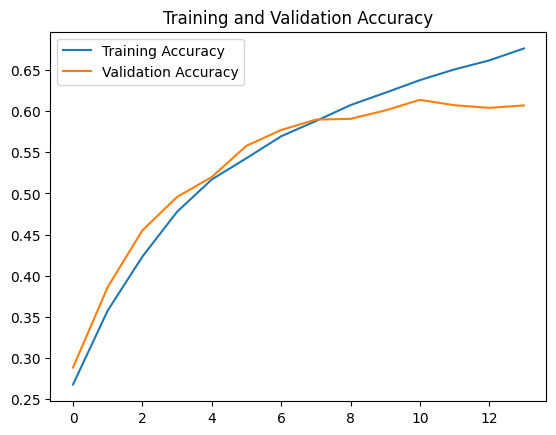

In [ ]:
plt.plot(historyGRU.history['accuracy'], label='Training Accuracy')
plt.plot(historyGRU.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

###Model Evaluation:


> LSTM VS GRU (Training Accuracy vs Validation Accuracy) -




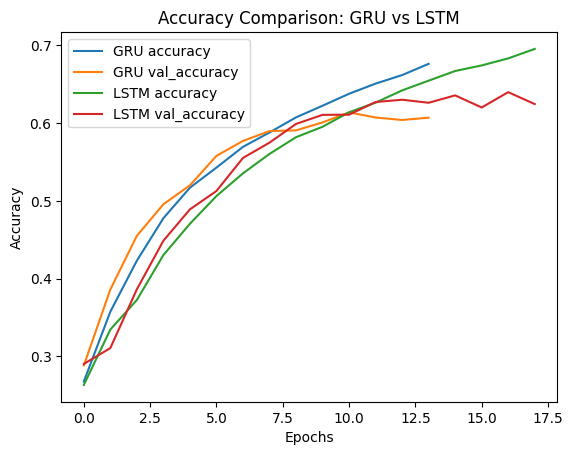

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison(history1, history2, metric, model1_name, model2_name):
    plt.plot(history1.history[metric], label=f'{model1_name} {metric}')
    plt.plot(history1.history[f'val_{metric}'], label=f'{model1_name} val_{metric}')
    plt.plot(history2.history[metric], label=f'{model2_name} {metric}')
    plt.plot(history2.history[f'val_{metric}'], label=f'{model2_name} val_{metric}')
    plt.title(f'{metric.capitalize()} Comparison: {model1_name} vs {model2_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Plot Accuracy Comparison
plot_comparison(historyGRU, historyLSTM, 'accuracy', 'GRU', 'LSTM')



> LSTM VS GRU (Performance) -



129/129 [==============================] - 11s 87ms/step


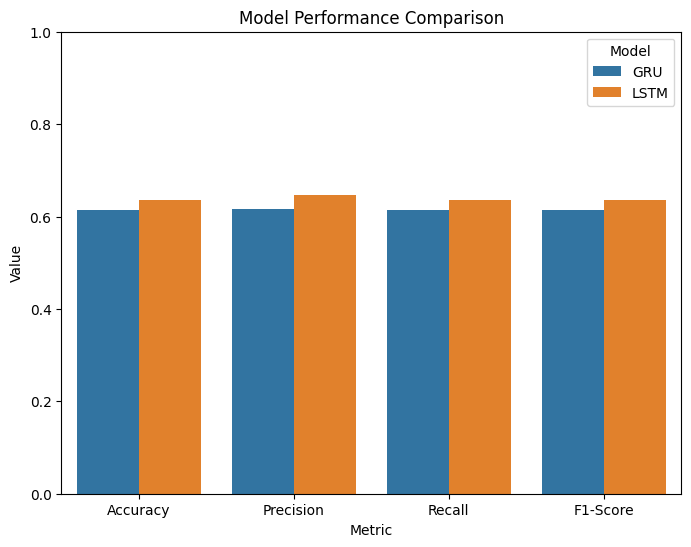

In [ ]:
y_val_classes = np.argmax(y_val, axis=1)
y_pred_gru = np.argmax(modelGRU.predict(X_val), axis=1)
y_pred_lstm = np.argmax(modelLSTM.predict(X_val), axis=1)

# Evaluate GRU
gru_accuracy = accuracy_score(y_val_classes, y_pred_gru)
gru_precision = precision_score(y_val_classes, y_pred_gru, average='weighted')
gru_recall = recall_score(y_val_classes, y_pred_gru, average='weighted')
gru_f1 = f1_score(y_val_classes, y_pred_gru, average='weighted')

# Evaluate LSTM
lstm_accuracy = accuracy_score(y_val_classes, y_pred_lstm)
lstm_precision = precision_score(y_val_classes, y_pred_lstm, average='weighted')
lstm_recall = recall_score(y_val_classes, y_pred_lstm, average='weighted')
lstm_f1 = f1_score(y_val_classes, y_pred_lstm, average='weighted')


data = {'Model': ['GRU', 'LSTM'], 'Accuracy': [gru_accuracy, lstm_accuracy], 'Precision': [gru_precision, lstm_precision], 'Recall': [gru_recall, lstm_recall], 'F1-Score': [gru_f1, lstm_f1]}

df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=df_melted)
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.show()